In [1]:
from fastai2.vision.all import *
from siren import siren_model

In [2]:
pipe = Pipeline([PILImage.create, ToTensor, IntToFloatTensor, Resize(256)])
image = pipe("yorkshire_terrier_9.jpg")

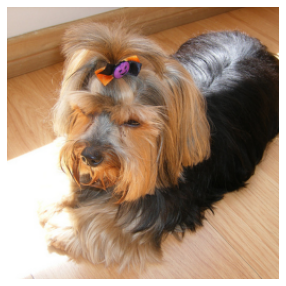

In [3]:
image.show();

In [4]:
y = image.reshape(3, -1).transpose(0, 1)
y.shape

torch.Size([65536, 3])

In [5]:
g0, g1 = torch.meshgrid([torch.arange(-1, 1, step=2/256), torch.arange(-1, 1, step=2/256)])
x = torch.cat([g0.flatten().unsqueeze(1), g1.flatten().unsqueeze(1)], dim=1)
x = x.float()
x.shape

torch.Size([65536, 2])

In [6]:
# Just making sure that the pixels are still in the same relative place
for coord, pixel_value in zip(x, y):
    c = ( 128 * (1 + coord)).long()
    assert (image[:, c[0], c[1]] == pixel_value).all(), "Pixel values do not match"

In [7]:
from torch.utils.data import TensorDataset
dset = TensorDataset(x.cuda(), y.cuda())

In [8]:
dls = DataLoaders(DataLoader(dset, bs=256), DataLoader(dset, bs=4096))

In [9]:
learn = Learner(dls, 
    siren_model([2, 256, 128, 64, 32, 3]).cuda(), 
    loss_func=MSELossFlat(),
    opt_func=ranger           
    )

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.010964781977236271)

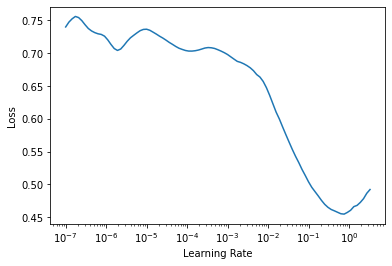

In [10]:
learn.lr_find()

In [119]:
learn.fit_flat_cos(300, lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.127543,0.147291,00:02
1,0.058894,0.077343,00:02
2,0.029648,0.045901,00:02
3,0.017210,0.037833,00:02
4,0.013401,0.042150,00:02
5,0.012540,0.044387,00:02
6,0.012527,0.043999,00:02
7,0.011177,0.043559,00:02
8,0.009967,0.046106,00:02
9,0.009605,0.038070,00:02


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


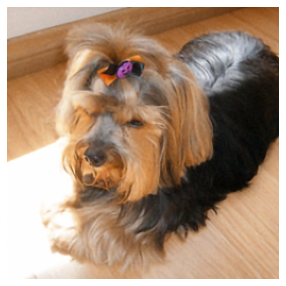

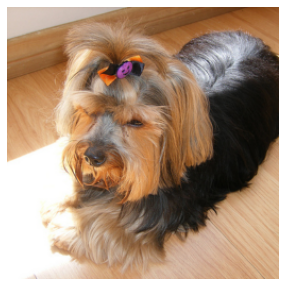

In [120]:
# Top one is from model, bottom is the original image
y_hat = learn.model(x.cuda())
TensorImage(y_hat.transpose(0, 1).reshape(3, 256, 256)).show()
TensorImage(orig_y[0]).show();

In [121]:
# Number of pixels on the image
256*256*3

196608

In [122]:
# Number of parameters on the model
sum([p.numel() for p in learn.model.parameters()])

44099